In [1]:
import cv2, glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# For preprocessing
from skimage.exposure import rescale_intensity
from skimage.morphology import disk, square, erosion, dilation, area_closing, remove_small_objects, opening, closing
from skimage.util import invert

# Initialization / Loading data

In [2]:
# Path containing testing / training data
test_path = '../Data/'
train_path = '../Data/TRAIN/'

In [3]:
def read_csv_or_none(csv_path):
    try:
        return pd.read_csv(csv_path, header=None)
    except:
        return None

In [4]:
def plot_img(img, gt=None, title='', cmap='gray', scatter=30):
    plt.title(title)
    plt.imshow(img, cmap=cmap)
    
    if gt is not None:
        xs = list(gt[0])
        ys = list(gt[1])
        for idx in range(len(xs)):
            j, i = ys[idx], xs[idx]
            plt.scatter(j, i, color='r', s=scatter)

## Testing data

In [5]:
# Init testing data
test_img_list = []
test_csv_list = []
test_title_list = []

for file in glob.glob(test_path + '*.jpg'):
    test_img_list.append(cv2.imread(file))
    test_csv_list.append(read_csv_or_none(file[:-3] + 'csv'))
    test_title_list.append(file[:-4])
    
test_nb_images = len(test_img_list)
print('Testing dataset contains {} images'.format(test_nb_images))

Testing dataset contains 5 images


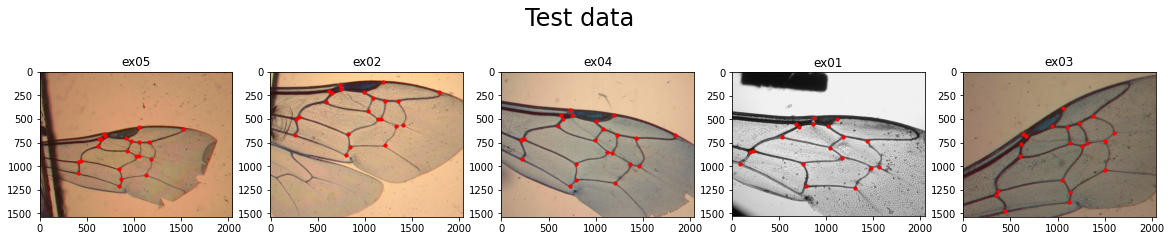

In [6]:
# Display images

plt.figure(figsize=(20, 4))
for i in range(test_nb_images):
    title = test_title_list[i].split('/')[-1]
    
    plt.subplot(1, test_nb_images, i + 1)
    plot_img(test_img_list[i], test_csv_list[i], title, scatter=10)
    
plt.suptitle('Test data', fontsize=24)
plt.show()

## Training data

In [7]:
# Init training data
train_img_list = []
train_csv_list = []
train_title_list = []

for file in glob.glob(train_path + '*.jpg'):
    train_img_list.append(cv2.imread(file))
    train_csv_list.append(read_csv_or_none(file[:-3] + 'csv'))
    train_title_list.append(file[:-4])
    

train_nb_images = len(train_img_list)
print('Training dataset contains {} images'.format(train_nb_images))

Training dataset contains 32 images


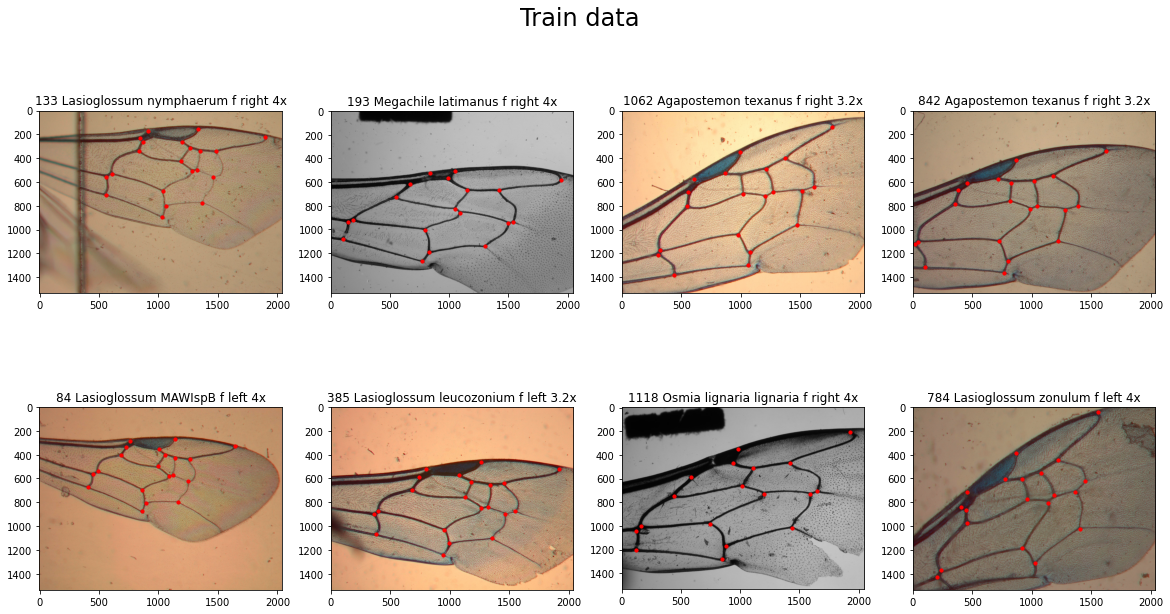

In [8]:
# Display first 8 images

plt.figure(figsize=(20, 10))
for i in range(8):
    title = train_title_list[i].split('/')[-1]
    
    plt.subplot(2, 4, i + 1)
    plot_img(train_img_list[i], train_csv_list[i], title, scatter=10)
    
plt.suptitle('Train data', fontsize=24)
plt.show()

# Image preprocessing

### 1 - Grayscale

In [9]:
def RGB_to_gray(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

### 2 - Rescale intensity

In [10]:
def apply_intensity_rescale(img):
    p1, p2 = np.percentile(img, (10, 95))
    return rescale_intensity(img, in_range=(p1, p2))

### 3 - Threshold

In [11]:
def apply_threshold(img, threshold_value):
    _, img = cv2.threshold(img, threshold_value, 255, 0)
    return img

### 4 - Remove small objects

In [12]:
def remove_small_obj(img, min_size):
    tmp = (invert(img) > 0).copy()
    tmp = remove_small_objects(tmp, min_size=min_size)
    return invert(tmp)

### 5 - Opening

In [13]:
def apply_opening(img, footprint):
    return opening(img, footprint)

### 6 - Closing

In [14]:
def apply_closing(img, footprint):
    return closing(img, footprint)

### 7 - Connected Components

In [15]:
def compute_connected_components(img):
    return cv2.connectedComponents(img.astype(np.uint8))[1]

### Preprocessing pipeline

In [16]:
def print_string_if_true(condition, string):
    if condition:
        print(string)

def apply_preprocessing(img, display=False, verbose=False):
    img_list = [img]
    
    print_string_if_true(verbose, "1 - RGB to gray")
    img_list.append(RGB_to_gray(img_list[-1]))
    
    print_string_if_true(verbose, "2 - Intensity rescale")
    img_list.append(apply_intensity_rescale(img_list[-1]))
    
    print_string_if_true(verbose, "3 - Threshold")
    img_list.append(apply_threshold(img_list[-1], 100))
    
    print_string_if_true(verbose, "4 - Remove small objects")
    img_list.append(remove_small_obj(img_list[-1], 300))
    
    print_string_if_true(verbose, "5 - Opening")
    img_list.append(apply_opening(img_list[-1], disk(5)))
    
    print_string_if_true(verbose, "6 - Closing")
    img_list.append(apply_closing(img_list[-1], square(2)))
    
    print_string_if_true(verbose, "7 - Connected components")
    img_list.append(compute_connected_components(img_list[-1]))
    
    if display:
        plt.figure(figsize=(20, 10))
        
        plt.subplot(2, 4, 1)
        plt.imshow(img_list[0])
        plt.title('Original image')

        for i in range(1, 7):
            plt.subplot(2, 4, i + 1)
            plt.imshow(img_list[i], cmap='gray')
            plt.title('Step {}'.format(i))
        
        plt.subplot(2, 4, 8)
        plt.imshow(img_list[-1], cmap='turbo')
        plt.title('Step 7')

        plt.show()
    
    return img_list[-1]

**FIXME : Preprocessing does not work well for train_img_list[-5]**

1 - RGB to gray
2 - Intensity rescale
3 - Threshold
4 - Remove small objects
5 - Opening
6 - Closing
7 - Connected components


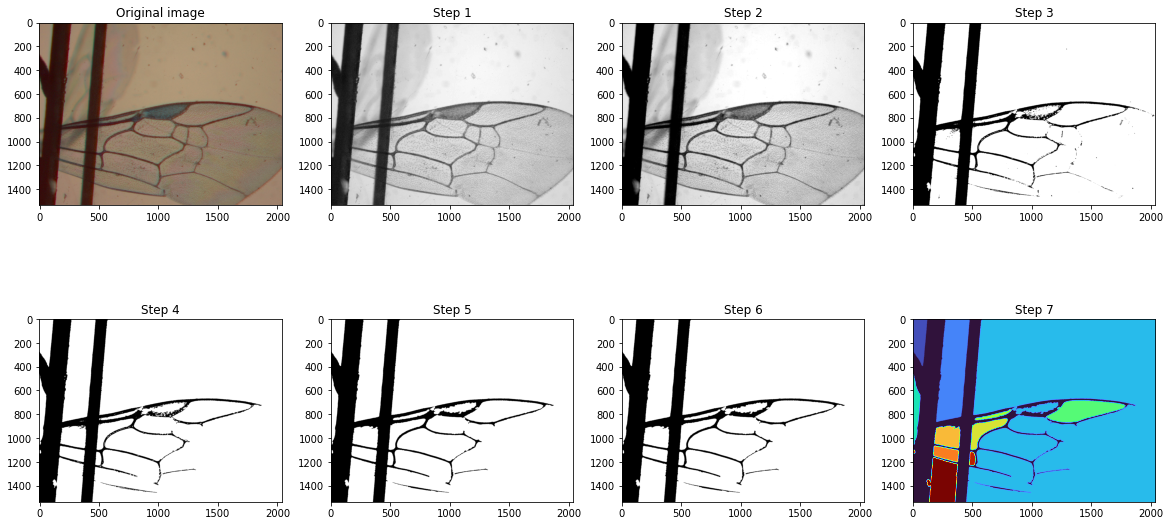

In [17]:
# Apply preprocessing for a random image of one of the datasets
_ = apply_preprocessing(train_img_list[-5], display=True, verbose=True)

## Testing data

In [18]:
test_preprocessed_img_list = []

for i in range(test_nb_images):
    title = test_title_list[i].split('/')[-1]
    print('Apply preprocessing on {}'.format(title))
    
    preprocessed_img = apply_preprocessing(test_img_list[i])
    test_preprocessed_img_list.append(preprocessed_img)

Apply preprocessing on ex05
Apply preprocessing on ex02
Apply preprocessing on ex04
Apply preprocessing on ex01
Apply preprocessing on ex03


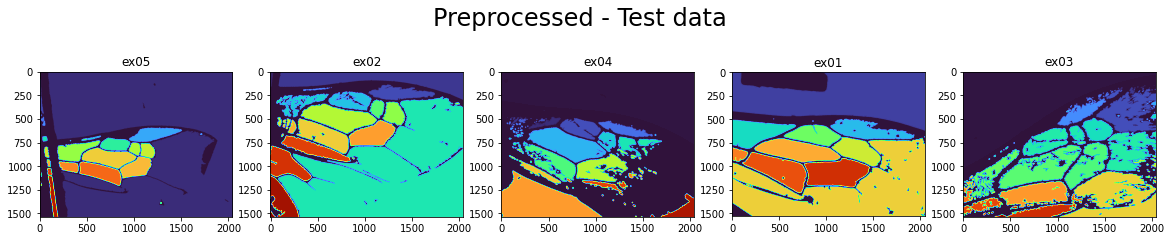

In [19]:
# Display images

plt.figure(figsize=(20, 4))
for i in range(test_nb_images):
    title = test_title_list[i].split('/')[-1]
    
    plt.subplot(1, test_nb_images, i + 1)
    plt.imshow(test_preprocessed_img_list[i], cmap='turbo')
    plt.title(title)
    
plt.suptitle('Preprocessed - Test data', fontsize=24)
plt.show()

## Training data

In [20]:
train_preprocessed_img_list = []

for i in range(train_nb_images):
    title = train_title_list[i].split('/')[-1]
    print('Apply preprocessing on {}'.format(title))
    
    preprocessed_img = apply_preprocessing(train_img_list[i])
    train_preprocessed_img_list.append(preprocessed_img)

Apply preprocessing on 133 Lasioglossum nymphaerum f right 4x
Apply preprocessing on 193 Megachile latimanus f right 4x
Apply preprocessing on 1062 Agapostemon texanus f right 3.2x
Apply preprocessing on 842 Agapostemon texanus f right 3.2x
Apply preprocessing on 84 Lasioglossum MAWIspB f left 4x
Apply preprocessing on 385 Lasioglossum leucozonium f left 3.2x
Apply preprocessing on 1118 Osmia lignaria lignaria f right 4x
Apply preprocessing on 784 Lasioglossum zonulum f left 4x
Apply preprocessing on 004 Osmia lignaria f right 4x
Apply preprocessing on 7 Lasioglossum leucozonium f left 3.2x
Apply preprocessing on 913 Lasioglossum leucozonium f left 3.2x
Apply preprocessing on 62 Lasioglossum rohweri f right 4x
Apply preprocessing on 41 Lasioglossum rohweri f right 4x
Apply preprocessing on 119 Lasioglossum rohweri f left 4x
Apply preprocessing on 8 Lasioglossum zephyrum f left 4x
Apply preprocessing on 149 Lasioglossum rohweri f left 4x
Apply preprocessing on 105 Lasioglossum pilosum f

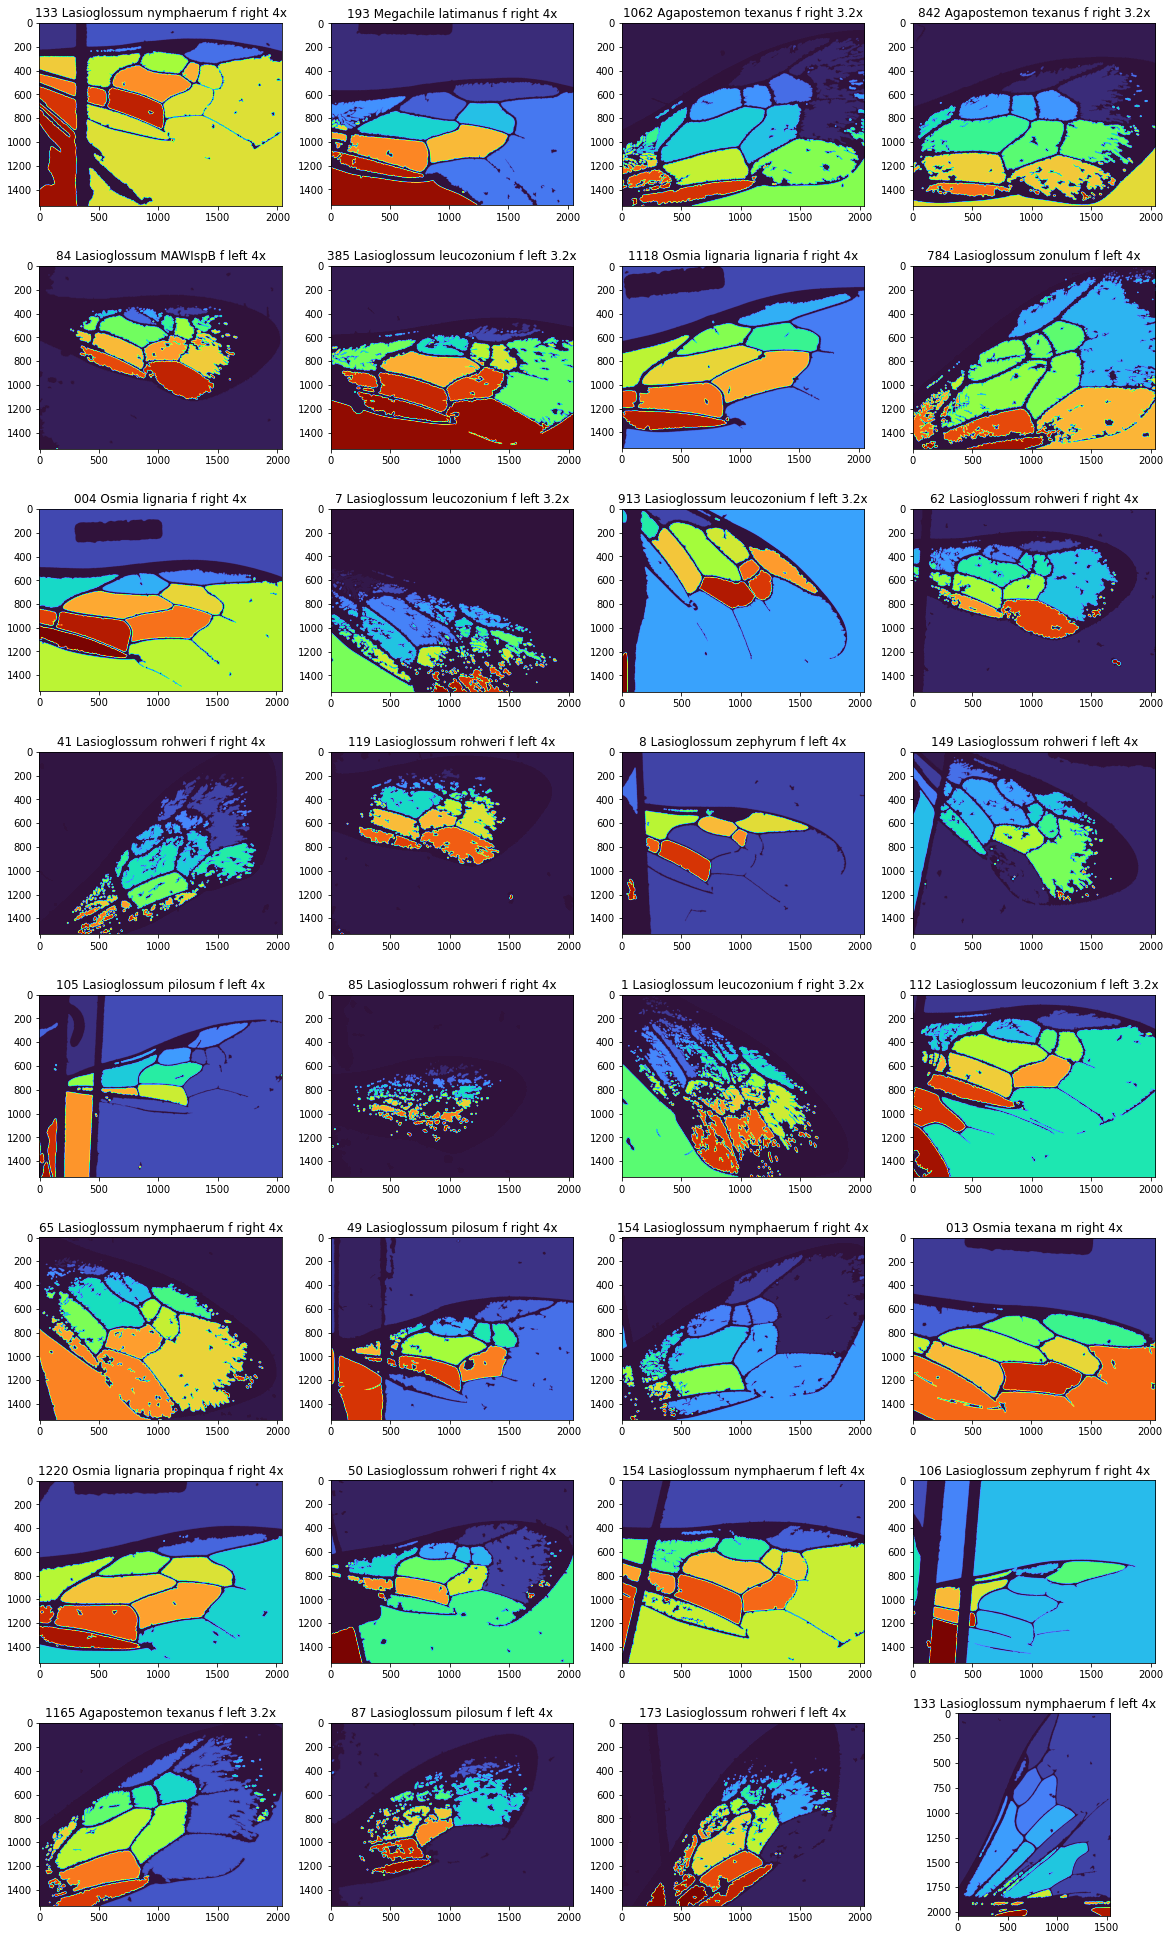

In [21]:
# Display 4 images per line

plt.figure(figsize=(20, 35))
for i in range(train_nb_images):
    title = train_title_list[i].split('/')[-1]
    
    plt.subplot(8, 4, i + 1)
    plt.imshow(train_preprocessed_img_list[i], cmap='turbo')
    plt.title(title)
    
plt.show()

# Intersections detection